<a href="https://colab.research.google.com/github/kumar-abhishek/handson-ml2/blob/master/%5BML310%2BLesson1%5D%2BIntroduction%2Bto%2BAdvanced%2BMachine%2BLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification

While binary classifiers are used to distinguish between two classes (e.g. detect if a transaction is a fraudulent one, classify an email into either spam or non-spam and etc.), multiclass classifiers distinguish between more than two classes. For example, we want to predict a picture of the Iris Flower into a set of predefined species. While some algorithms (e.g. K nearest neighbors and naive bayes classifier) can extend to handle multiple classes naturally, others are less obvious (e.g. Support Vector Machine). 

There are various ways that we can use to perform multiclass classification by leveraging any binary classifiers. In this exercise, you will implement two such strategies for multiclass classification: _One-versus-all_ strategy and _One-versus-one_ strategy.

- **One-versus-all (OvA)**: In this strategy, we train a single binary classifier per class, with the samples of that class as positive samples and all other samples as negatives. During inference, we get the prediction from each classifier and select the class with the highest score. This strategy is also called the one-versus-the-rest strtegey. 

- **One-versus-one (OvO)**: In this strategy, we train a binary classifier for every pair of classes. If there are N classes in the problem, you need to train N * (N-1) / 2 classifiers. During inference, we have to run through all N * (N-1) / 2 classifiers and ses which class wins the most votes. The main advantage of OvO strategy is that each binary classifier only needs to be train on the part of the training dataset for the two classes that it needs to separate. 

In [0]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# make this notebook's output stable across runs
np.random.seed(0)

## MNIST Dataset

In this lab assignment, we use the classic machine learning benchmark dataset **MNIST** assembed by the National Institute of Standards and Technology in the 1980s. The MNIST dataset includes 60K training and 10K test images of grayscale handwriting images and the task is to classify these images into 10 classes (0 through 9).

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Both the train and test CSV files have 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [0]:
# Load train and test data from CSV files.
train = pd.read_csv("mnist_train.csv", header=None)
test = pd.read_csv("mnist_test.csv", header=None)

train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

In [15]:
# Output the number of images in each class in the train and test datasets.
print(train_y.value_counts().sort_index())
print(test_y.value_counts().sort_index())

0    1948
1    2356
2    1977
3    2027
4    1949
5    1783
6    1973
7    2099
8    1918
9    1970
Name: 0, dtype: int64
0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
Name: 0, dtype: int64


Here we define two helper functions which plot the image of an instance for data exploration and debugging.

In [0]:
def plot_digit(x, y):
    """
    Plot a single image of the MNIST dataset
    """
    plt.imshow(np.reshape(x.values, (28, 28)), cmap='gray_r')
    plt.title('Digit Label: {}'.format(y))
    plt.show()

def plot_digits(x, y):
    """
    Plot the image of the digits in MNIST dataset
    """
    plt.clf()
    plt.style.use('seaborn-muted')

    fig, axes = plt.subplots(
    3,3, 
    figsize=(5,5),
    sharex=True, sharey=True,
    subplot_kw=dict(adjustable='box', aspect='equal'))

    for i in range(0, 9):
        # Idnetify the subgraph given class i.
        subplot_row = i // 3 
        subplot_col = i % 3 
        ax = axes[subplot_row, subplot_col]

        # Plot image on subplot.
        ax.imshow(np.reshape(x.iloc[i,:].values, (28, 28)), cmap='gray_r')

        ax.set_title('Digit Label: {}'.format(y[i]))
        ax.set_xbound([0,28])

    plt.tight_layout()
    plt.show()

### Plot a single image in MNIST dataset

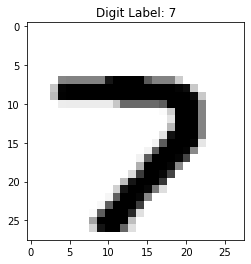

In [22]:
idx = 3
plot_digit(train_x.iloc[idx,:], train_y[idx])

### View the digit images from class 1 to 9.

To better understand the MNIST dataset, we plot the first occurence of each class (1-9) in the train dataset using the grayscale inputs.

In the following code, we plot nine images of digits 0 in the train dataset. 

<Figure size 432x288 with 0 Axes>

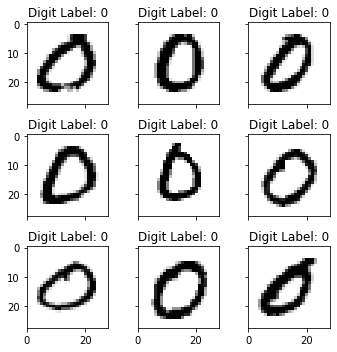

In [23]:
# Find the first 9 occurrences of digit zero in the train dataset
zero_digit_idx = list(train_y[train_y == 0].index[0:9])

# Plot digits
plot_digits(train_x.iloc[zero_digit_idx,:], train_y[zero_digit_idx].values)

<span style="color:orange">**Coding Part 1: Plot the first image of digits 1 to 9 in the training dataset**</span> 

<Figure size 432x288 with 0 Axes>

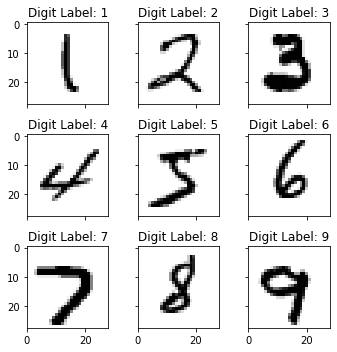

In [24]:
# Find the first occurrence of each class in the train dataset
idx = [-1] * 9
for i in range(1, 10):
  # Find the first image from the class i.
  idx[i-1] = train_y[train_y == i].index[0]

# Plot digits
plot_digits(train_x.iloc[idx,:], train_y[idx].values)

---

### Classify even digits.
To reduce the computational assumption, we simplify the problem to classify only the odd numbers, ie. 1, 3, 5, 7, and 9, instead of all 10 digits. 

In [0]:
# helper functions
def sample_data(x, y, digits):
    """
    Sample a subset of all the images based on the digits provided
    """
    idx = []
    for i in digits:
        idx = idx + list(y.index[y == i])

    return (x.iloc[idx,:], y.iloc[idx])

def evaluate(y, z):
    """
    Evaluate the classification accuracy and also generate the confusion matrix. 
    """
    confusion_matrix = pd.crosstab(y, z, rownames=['Actual'], colnames=['Predicted'])
    accuracy = sum(np.diag(confusion_matrix)) / confusion_matrix.values.sum()

    return (accuracy, confusion_matrix)

In [26]:
# generate the final dataset for model training for the given digits
digits = [1, 3, 5, 7, 9]
tr_x, tr_y = sample_data(train_x, train_y, digits)
te_x, te_y = sample_data(test_x, test_y, digits)
print(tr_x)

       1    2    3    4    5    6    7    ...  778  779  780  781  782  783  784
2        0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11       0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
42       0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
46       0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
47       0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
19985    0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19990    0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19994    0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19995    0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19998    0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[10235 rows x 784 columns]


## One-versus-all (OvA) strategy
<span style="color:orange">**Coding Part 2: In this session, you will implement the OvA stragety for multiclass classification using logistic regression as the base binary classifier. After the implementation, you will apply it to the MNIST dataset and see its performance.**</span> 

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

class OvA(object):
    """
    OvA strategy for multiclass classification.
    """
    def __init__(self):
         self.logit = OneVsRestClassifier(SVC())

    def train(self, x, y):
        """
        TODO: Train the multiclass classifier using OvA strategy. 
        """
        #self.logit.fit(tr_x, tr_y)
        self.logit.fit(x, y)

    def predict(self, x):
        """
        TODO: Make predictions on multiclass problems using the OvA strategy. 
        """
        return self.logit.predict(x)

### Train the OvA multiclass classifier on MNIST dataset

In [0]:
ova = OvA()
ova.train(tr_x, tr_y)

In [29]:
print('adf')

adf


### Predict on the test dataset using OvA multiclass classifier

In [30]:
te_z_ova = ova.predict(te_x)
print(te_z_ova)
print('12')

[1 1 1 ... 9 9 9]
12


### Evaluate the performance of OvA

In [31]:
ova_accuracy, ova_confuction_matrix = evaluate(te_y.values, te_z_ova)
print("Accuracy of OvA classifier is {}.".format(ova_accuracy))
print("Confusion matrix of OvA classifier: \n {}".format(ova_confuction_matrix))

Accuracy of OvA classifier is 0.9806858494284588.
Confusion matrix of OvA classifier: 
 Predicted     1    3    5     7    9
Actual                              
1          1130    3    1     1    0
3             0  992    8     7    3
5             1   12  877     0    2
7            11    4    3  1000   10
9             6   13    5     8  977


---

## One-versus-one (OvO) strategy
<span style="color:orange">**Coding Part 3: In this session, you will implement the OvO stragety for multiclass classification using logistic regression as the base binary classifier. After the implementation, you will apply it to the MNIST dataset and see its performance.**</span> 

In [0]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

class OvO():
    """
    OvO strategy for multiclass classification.
    """
    clf_onevsone = OneVsOneClassifier(LinearSVC(random_state=0))
    def __init__(self):
      pass
    def train(self, x, y):
        """
        TODO: Train the multiclass classifier using OvO strategy. 
        """
        self.clf_onevsone.fit(x, y)

    def predict(self, x):
        """
        TODO: Make predictions on multiclass problems using the OvO strategy. 
        """
        return self.clf_onevsone.predict(x)

### Train the OvO multiclass classifier on MNIST dataset

In [38]:
ovo = OvO()
ovo.train(tr_x, tr_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

### Predict on the test dataset using OvO multiclass classifier

In [0]:
te_z_ovo = ovo.predict(te_x)

### Evaluate the performance of OvO

In [40]:
ovo_accuracy, ovo_confuction_matrix = evaluate(te_y.values, te_z_ovo)
print("Accuracy of OvO classifier is {}.".format(ovo_accuracy))
print("Confusion matrix of OvO classifier: \n {}".format(ovo_confuction_matrix))

Accuracy of OvO classifier is 0.9347654710287742.
Confusion matrix of OvO classifier: 
 Predicted     1    3    5    7    9
Actual                             
1          1126    4    3    2    0
3             2  939   48   11   10
5             3   70  795    5   19
7             3   31    2  950   42
9             5   11   16   44  933


### End of ML 310 Lab Assignment 1
---
